## 비지도학습 예제 1번

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# 데이터 로드
df = pd.read_csv('data/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


클러스터별 평균 특성:
         fixed acidity  volatile acidity  citric acid  residual sugar  \
cluster                                                                 
0             7.189889          0.609342     0.123047        2.214058   
1            10.067131          0.405080     0.469761        2.582570   
2             8.155467          0.535173     0.289680        3.105467   

         chlorides  free sulfur dioxide  total sulfur dioxide   density  \
cluster                                                                   
0         0.078553            13.507618             34.894737  0.995896   
1         0.100460            10.888446             30.627490  0.997574   
2         0.087235            27.108000             89.954667  0.997276   

               pH  sulphates    alcohol  
cluster                                  
0        3.405762   0.609224  10.494044  
1        3.195040   0.752131  10.724037  
2        3.284267   0.626533   9.883156  

클러스터별 품질 점수 분포:
quality         3 

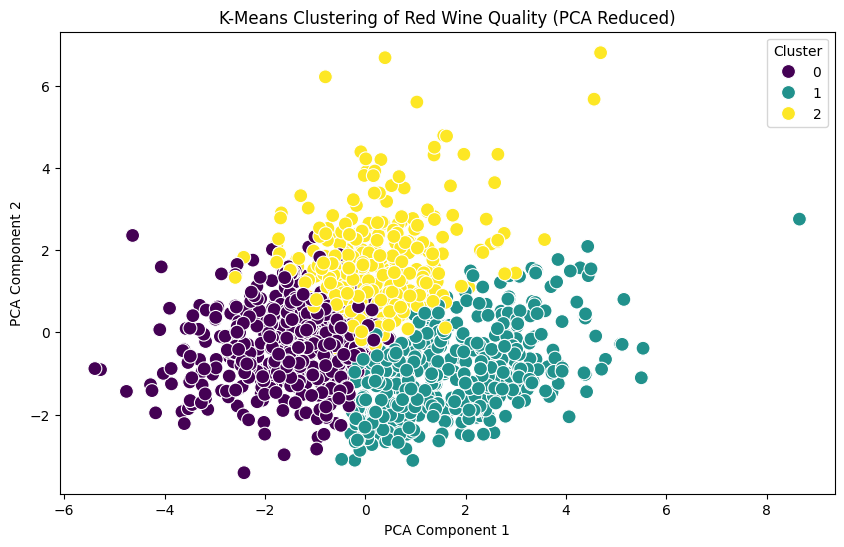

In [ ]:
# 데이터 전처리
# 특성 선택 (품질 점수를 제외한 화학적 특성)
features = df.drop('quality', axis=1).columns
# X는 클러스터링에 사용될 입력 데이터. 품질 점수는 클러스터링에 사용하지 않음. 
# X는 이제 와인의 품질 점수를 제외한 순수한 화학적 특성 데이터만 포함. 
X = df[features]    


# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# K-Means 클러스터링. 유클리드 거리를 기반으로 유사성 판별.
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


# 클러스터별 특성 분석
cluster_summary = df.groupby('cluster')[features].mean()
print("클러스터별 평균 특성:")
print(cluster_summary)


# quality_by_clister: 각 클러스터내에서 각각의 quality가 차지하는 비율을 보여주는 데이터프레임
# 1. 클러스터별로 그룹화한 후 quality 선택
# 2. quality 별로 갯수를 세고, 이를 해당 클러스터 내의 총 와인 수로 나누어 '비율(normalize=True)'로 변환
# 3. Series 형태 결과를 .unstack()을 사용하여, 클러스터를 인덱스로 & 품질 점수를 값으로 가지는 데이터프레임으로 변환
quality_by_cluster = df.groupby('cluster')['quality'].value_counts(normalize=True).unstack()
print("\n클러스터별 품질 점수 분포:")
print(quality_by_cluster)


# PCA를 사용한 2차원 시각화
pca = PCA(n_components=2)
# 각 와인 샘플이 2개의 새로운 차원으로 표현된 Numpy 배열
X_pca = pca.fit_transform(X_scaled)



# 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='viridis', s=100)
plt.title('K-Means Clustering of Red Wine Quality (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

## 비지도학습 예제 2번

In [41]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.utils import resample

In [42]:
# 데이터 로드

df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [43]:
# 데이터 탐색
print("데이터 요약 정보:")
print(df.info())
print("\n결측치 확인:")
print(df.isnull().sum())


데이터 요약 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21 


Isolation Forest - 이상치 수: 485
Isolation Forest - 정상치 수: 284322

DBSCAN - 이상치 수: 26500
DBSCAN - 정상치 수: 1980

Isolation Forest 성능:
정밀도: 0.2515
재현율: 0.2480
F1 스코어: 0.2497
ROC-AUC: 0.6233

Isolation Forest 분류 보고서:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.25      0.25      0.25       492

    accuracy                           1.00    284807
   macro avg       0.63      0.62      0.62    284807
weighted avg       1.00      1.00      1.00    284807



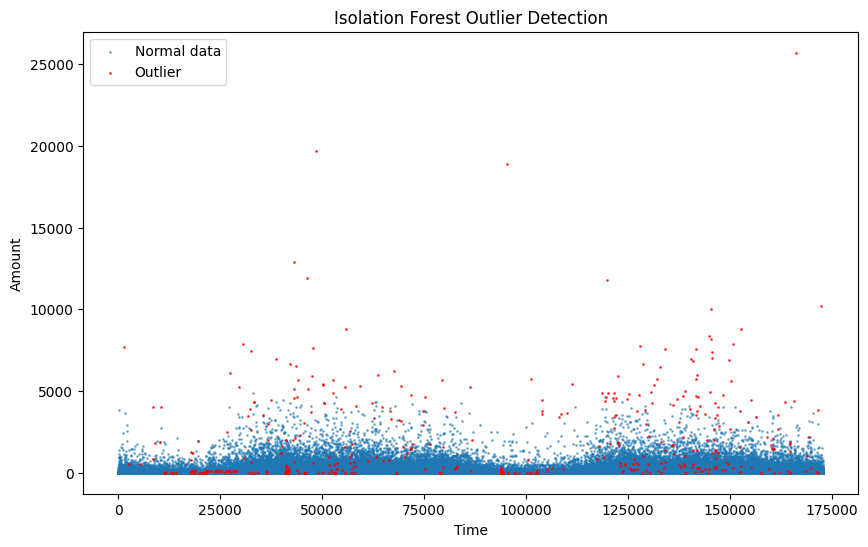


DBSCAN 성능 (샘플링 데이터):
정밀도: 0.0018
재현율: 1.0000
F1 스코어: 0.0037
ROC-AUC: 0.5348

DBSCAN 분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.07      0.13     28431
           1       0.00      1.00      0.00        49

    accuracy                           0.07     28480
   macro avg       0.50      0.53      0.07     28480
weighted avg       1.00      0.07      0.13     28480



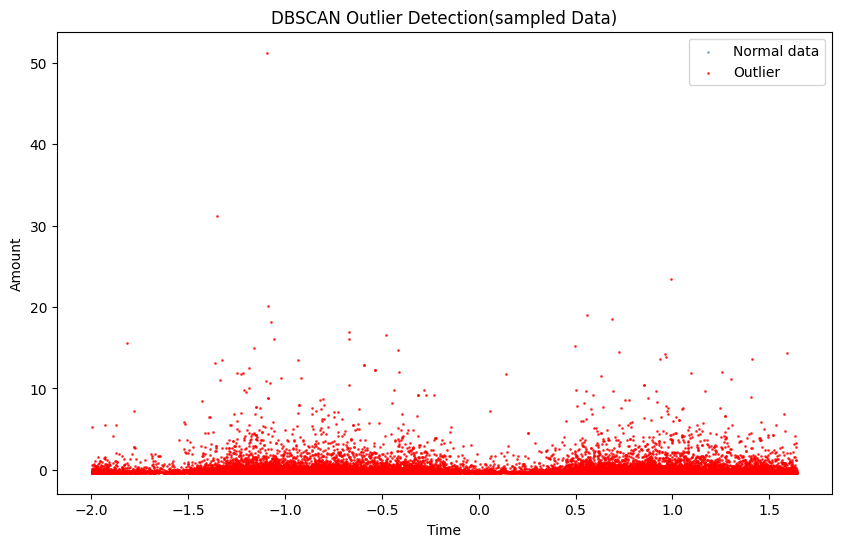

In [ ]:
# 특성과 라벨 분리
# features: 모델이 학습하고 예측하는 데 사용될 입력 특성들만 포함하는 데이터프레임
features = df.drop(columns=['Class'])  # 예측 변수인 'Class' 제외
#  모델의 예측 성능을 평가하는 데 사용될 정답 라벨 데이터
labels = df['Class']  # 평가용 라벨



# 데이터 전처리 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



# Isolation Forest 모델 (고립 트리를 사용하여 데이터를 분할하고, 이상치는 정상 데이터보다 더 적은 분할로 고립)
# 고립 트리 갯수: 100 / 이상치 비율: 0.0017 / 사용할 CPU 코어의 개수: -1 (모든 코어 사용)
iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42, n_jobs=-1)
iso_forest.fit(features_scaled)



# 이상치 예측 (-1: 이상치, 1: 정상 -> 1: 이상치, 0: 정상으로 변환)
y_pred_iso = [1 if x == -1 else 0 for x in iso_forest.predict(features_scaled)]
df['Anomaly_Iso'] = y_pred_iso



# 이상치와 정상 데이터 분리
outliers_iso = df[df['Anomaly_Iso'] == 1]
normal_iso = df[df['Anomaly_Iso'] == 0]
print(f"\nIsolation Forest - 이상치 수: {len(outliers_iso)}")
print(f"Isolation Forest - 정상치 수: {len(normal_iso)}")



# DBSCAN 모델 (밀도 기반의 클러스터링 알고리즘)
# 계산 시간 단축을 위해 샘플링 (10%) 사용
# Stratified=label:  원본 데이터셋의 labels (즉, 정상/사기 거래 비율) 비율을 샘플링된 데이터에서도 동일하게 유지
X_sampled, y_sampled = resample(features_scaled, labels, n_samples=int(0.1 * len(features_scaled)), stratify=labels, random_state=42)
# 이웃 반경: 0.5 / 최소 이웃 샘플: 5
dbscan = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
dbscan.fit(X_sampled)



# 이상치 예측 (-1: 이상치, 그 외: 정상 -> 1: 이상치, 0: 정상으로 변환)
y_pred_dbscan = [1 if x == -1 else 0 for x in dbscan.labels_]



# 샘플링된 데이터에 대한 결과 저장
data_sampled = pd.DataFrame(X_sampled, columns=features.columns)
data_sampled['Class'] = y_sampled.values
data_sampled['Anomaly_DBSCAN'] = y_pred_dbscan
outliers_dbscan = data_sampled[data_sampled['Anomaly_DBSCAN'] == 1]
normal_dbscan = data_sampled[data_sampled['Anomaly_DBSCAN'] == 0]
print(f"\nDBSCAN - 이상치 수: {len(outliers_dbscan)}")
print(f"DBSCAN - 정상치 수: {len(normal_dbscan)}")





# 성능 평가 (Isolation Forest)
print("\nIsolation Forest 성능:")
print(f"정밀도: {precision_score(labels, y_pred_iso, zero_division=0):.4f}")
print(f"재현율: {recall_score(labels, y_pred_iso, zero_division=0):.4f}")
print(f"F1 스코어: {f1_score(labels, y_pred_iso, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(labels, y_pred_iso):.4f}")
print("\nIsolation Forest 분류 보고서:")
print(classification_report(labels, y_pred_iso, zero_division=0))


# 시각화 (Isolation Forest)
plt.figure(figsize=(10, 6))
plt.scatter(normal_iso['Time'], normal_iso['Amount'], label='Normal data', s=1, alpha=0.5)
plt.scatter(outliers_iso['Time'], outliers_iso['Amount'], label='Outlier', color='red', s=1, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('Isolation Forest Outlier Detection')
plt.legend()
plt.show()





# 성능 평가 (DBSCAN, sampled data - due to performance. it takes too much time TT)
print("\nDBSCAN 성능 (샘플링 데이터):")
print(f"정밀도: {precision_score(y_sampled, y_pred_dbscan, zero_division=0):.4f}")
print(f"재현율: {recall_score(y_sampled, y_pred_dbscan, zero_division=0):.4f}")
print(f"F1 스코어: {f1_score(y_sampled, y_pred_dbscan, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_sampled, y_pred_dbscan):.4f}")
print("\nDBSCAN 분류 보고서:")
print(classification_report(y_sampled, y_pred_dbscan, zero_division=0))


# 시각화 (DBSCAN, sampled data - due to performance. it takes too much time TT)
plt.figure(figsize=(10, 6))
plt.scatter(normal_dbscan['Time'], normal_dbscan['Amount'], label='Normal data', s=1, alpha=0.5)
plt.scatter(outliers_dbscan['Time'], outliers_dbscan['Amount'], label='Outlier', color='red', s=1, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Amount')
plt.title('DBSCAN Outlier Detection(sampled Data)')
plt.legend()
plt.show()



# 결과 저장
# outliers_iso.to_csv('data/outliers_isolation_forest.csv', index=False)
# outliers_dbscan.to_csv('data/outliers_dbscan.csv', index=False)
# print("\n이상치 탐지 결과가 'outliers_isolation_forest.csv'와 'outliers_dbscan.csv'에 저장되었습니다.")